In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class critic(object):
    def __init__(self, sess):
        
        self.sess = sess
        
        # w --> from generator
        self.w = tf.placeholder(dtype=tf.float32, shape=[None, 2])
        # x --> from data
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, 2])
        
        #self.big_x = tf.concat([self.w, self.x, self.z], axis=0)
        batch_size = tf.shape(self.w)[0]
        
        disc_w = self.discriminate(self.w)
        disc_x = self.discriminate(self.x)
        
        self.out = self.discriminate(
            tf.concat([self.w, self.x], axis=0)
        )
        
        e = tf.random.uniform(shape=tf.shape(self.w), minval=0., maxval=1.)
        self.z = e*self.x + (1 - e)*self.w
        
        disc_z = self.discriminate(self.z)
        
        self.grad_wrt_x = tf.gradients(
            disc_z,
            [self.z]
        )[0]
        
        self.grad_penalty = tf.reduce_mean(
            tf.square(
                tf.sqrt(
                    tf.reduce_sum(self.grad_wrt_x*self.grad_wrt_x, axis=1)
                ) - 1.
            )
        )
        
        self.wg_loss = tf.reduce_mean(disc_w - disc_x)
        
        self.loss = self.wg_loss + 10.*self.grad_penalty
        
        self.opt = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0, beta2=0.9)
        self.min_opt = self.opt.minimize(self.loss)
        
        radius = 5
        num_centers = 6
        self.centers = [np.array([radius*np.cos(t), radius*np.sin(t)]) for t in np.linspace(0, 2*np.pi - 2*np.pi/num_centers, num_centers)]
        
    def discriminate(self, X_in):
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE) as vs:
            num_layers = 3
        
            weights = []
            biases  = []
            layer_outs   = []

            ls = 512

            weights.append(tf.get_variable("w0", [2, ls], initializer=tf.initializers.orthogonal))
            biases.append(tf.get_variable("b0", [ls,], initializer=tf.initializers.random_normal))

            layer_outs.append(tf.nn.relu(tf.matmul(X_in, weights[-1]) + biases[-1]))

            for l in range(num_layers):
                index = l + 1
                weights.append(
                    tf.get_variable(
                        "w" + str(index),
                        [ls, ls],
                        initializer=tf.initializers.orthogonal
                    )
                )
                biases.append(
                    tf.get_variable(
                        "b" + str(index),
                        [ls,],
                        initializer=tf.initializers.random_normal
                    )
                )
                layer_outs.append(tf.nn.relu(tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]))

            weights.append(tf.get_variable("wout", [ls, 1], initializer=tf.initializers.orthogonal))
            biases.append(tf.get_variable("bout", [1,], initializer=tf.initializers.random_normal))

            full_out = tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]
            
            return full_out
        
    def train(self):
        # 1 means that the value came straight from the data distribution
        # 0 means that the value came from a generator (data + gaussian noise)
        batch_size = 512
        true_samples = self.get_distribution_samples(batch_size//2)
        gen_samples = self.get_distribution_samples(batch_size//2)
        
        labels = np.array([np.array([1., 1.]) if (i % 2 == 0) else np.array([0., 0.]) for i in range(batch_size)])
        interps = np.random.uniform(size=(batch_size//2, 2))
        offsets = np.array([np.random.normal([0, 0], scale=1.5) for _ in range(batch_size//2)])
        
        #print(true_samples.shape)
        #print(gen_samples.shape)
        #print(interps.shape)
        
        gen_samples = gen_samples + offsets
        
        fetches = [
            self.loss,
            self.min_opt,
            self.out,
            self.grad_penalty,
            #self.grads_and_vars,
            self.wg_loss
            #self.grad_wrt_x
        ]

        feeds = {
            self.x: true_samples,
            self.w: gen_samples,
            #self.e: interps,
            #self.z: interps*true_samples + (1. - interps)*gen_samples
        }
        
        #loss, opt, out, gp, gandv, dddx = self.sess.run(fetches, feeds)
        loss, opt, out, gp, wgloss = self.sess.run(fetches, feeds)
        #thing_out = self.sess.run(f2, feeds)
        #print("dddx:", dddx.shape)
        #print(thing_out)
        return loss, out, None, gp, wgloss
    
    def output_surface(self):
        xs = np.linspace(-12, 12, 200)
        ys = np.linspace(-12, 12, 200)
        
        query_points = []
        for x in xs:
            for y in ys:
                query_points.append([x, y])
        query_points = np.array(query_points)
        
        fetches = self.out
        feeds = {
            self.w: query_points[0:200*200//2, :],
            self.x: query_points[200*200//2:, :],
            self.z: np.zeros([200*200//2, 2])
        }
        
        out = self.sess.run(fetches, feeds)
        return query_points, out
    
    def get_distribution_samples(self, N=64):
        samples = []
        for n in range(N):
            d = np.random.choice([i for i in range(len(self.centers))])
            sample = np.random.normal(loc=self.centers[d], scale=1.0)
            samples.append(sample)
        
        return np.array(samples)

In [3]:
#plt.figure()
#plt.scatter([c[0] for c in c.centers], [c[1] for c in c.centers])
#plt.show()

In [4]:
sess = tf.Session()

c = critic(sess)
print(c.centers)
sess.run(tf.global_variables_initializer())

#print(c.train())

[array([5., 0.]), array([2.5       , 4.33012702]), array([-2.5       ,  4.33012702]), array([-5.00000000e+00, -1.60812265e-15]), array([-2.5       , -4.33012702]), array([ 2.5       , -4.33012702])]


In [5]:
#things = [np.random.normal([0, 0], scale=0.3) for _ in range(1000)]
things = c.get_distribution_samples(1000)

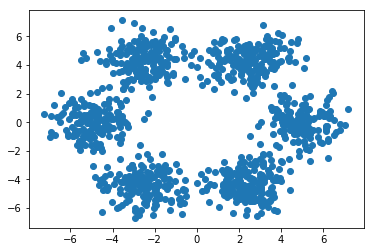

In [6]:
plt.figure()
plt.scatter([p[0] for p in things], [p[1] for p in things])
plt.show()

In [7]:
ret = None
derivs = []
losses = []
gandvs = []
gradpenalties = []
wglosses = []
weights = []
for i in range(5000):
    ret = c.train()
    #derivs.append(ret[-2])
    losses.append(ret[0])
    #gandvs.append(ret[2])
    gradpenalties.append(ret[3])
    wglosses.append(ret[4])
    #weights.append(sess.run(c.weights))
    if np.isnan(losses[-1]):
        print("Received NaN during training. Stopping.")
        break
#print(gandvs[0])
#print("wglosses:", wglosses)
#print("gradpenalties:", gradpenalties)

-0.29374737
(512, 1)
9.669385 -1.2787223


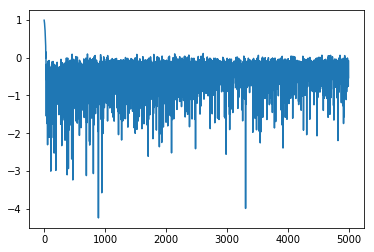

In [8]:
print(ret[0])
print(ret[1].shape)
#print(ret[2])
print(max(losses), min(losses))
plt.figure()
plt.plot(np.log10(np.abs(losses)))
#plt.plot(gradpenalties/max(gradpenalties))
plt.show()

In [9]:
ret[1].shape

(512, 1)

In [10]:
ret[0].shape

()

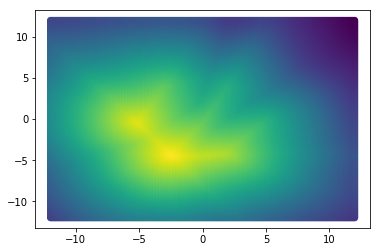

In [11]:
output_surface = c.output_surface()
b = np.max(output_surface[1])
a = np.min(output_surface[1])
y = output_surface[1]/(b - a) - a/(b - a)
plt.figure()
plt.scatter([p[0] for p in output_surface[0]], [p[1] for p in output_surface[0]], c=y[:, 0])
plt.show()

In [12]:
#output_surface[1].shape
np.max(output_surface[1])

7.806171

In [13]:
min(losses)

-1.2787223

In [14]:
losses[-1]

-0.29374737

In [15]:
losses[-2]

-0.3207236

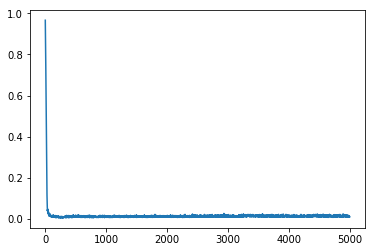

In [16]:
plt.figure()
plt.plot(gradpenalties)
plt.show()

In [17]:
min(losses)

-1.2787223